In [32]:
%run init_notebook.py

In [33]:
from src.utils import *
from src.processing import *
from matplotlib.pyplot import cm
    
from src.nlp_utils import run_parallel, evalute_optimal_smoothing
from src.utils import save_fig
from src.pymc_modelling import get_samp

In [61]:
tdet = load_pd_df("det_topics.feather")
tlda = load_pd_df("lda_cv_topics2.feather").reset_index()

## smooth individually

In [ ]:
# for each topic 25 Bayesian spline regression are fit
# source code can be found under src.nlp_utils -> runs in parralel

In [4]:
res = run_parallel(tlda.drop(['id'], axis=1), id_col='date')

This process ran 793.6


In [5]:
dict_compare_az, dict_best_nknot, dict_compare_traces, dict_data_grouped = {}, {}, {}, {}

for r in res:
    comp_az, best_k, comp_trace, data_g = r
    dict_compare_az.update(comp_az)
    dict_best_nknot.update(best_k)
    dict_compare_traces.update(comp_trace)
    dict_data_grouped.update(data_g)

In [ ]:
# for each topic the "optimal" model is calcualted based on the WAIC weight aggregation of individual predictions

In [7]:
dict_trace_optimal_agg = {}
for key in list(dict_compare_traces.keys()):
    _dict = {}
    _len = list(dict_compare_traces[key].values())[0].posterior['mu'].values.shape[-1]
    _trace_data = {
        # 'mu' is the mean as predicted by the model, take posterior mean across 200 samples
        k: dict_compare_traces[key][k].posterior['mu'].values[:, get_samp(1_000), :].reshape(2*100, _len).T.mean(axis=1) 
        for k in dict_compare_traces[key].keys()
    }
    _dict['df'] = pd.DataFrame(_trace_data, index=list(dict_data_grouped.values())[0].index)
    # aggregate 25 models by topic according to WAIC weights
    _dict['opt_agg'] = _dict['df'] @ dict_compare_az[key].weight
    dict_trace_optimal_agg[key] = _dict

In [ ]:
# df of optimal aggregation

In [36]:
tlda_ind = pd.DataFrame({k: dict_trace_optimal_agg[k]['opt_agg'] for k in dict_trace_optimal_agg.keys()})

In [37]:
tlda_ind['T_sum_ind_op_all'] = tlda_ind.sum(axis=1)
tlda_ind['T_sum_ind_op'] = tlda_ind.drop(['D_inflation', 'M_policy_counter', 'rest'], axis=1).sum(axis=1)

## smooth globally

In [71]:
tlda = tlda.drop(['id'], axis=1)

_dict = dict(zip(tlda.columns, list([float]*tlda.shape[1])))
_dict['date'] = "datetime64[ns]"
tlda = pd_df_astype(tlda, dict_dtypes=_dict)

tlda= tlda.set_index('date')
tlda['W'] = tlda.index.to_period('W').to_timestamp()

In [77]:
ser = tlda.drop(['M_policy', 'D_inflation', 'rest'], axis=1).groupby('W').last().sum(axis=1)
# ser2 = tlda.groupby('W').mean().sum(axis=1)

### model

In [83]:
%%capture
df, mods, trace = evalute_optimal_smoothing(ser, range(5, 200, 10))

In [84]:
trace_data = {
    k: trace[k].posterior['mu'].values[:, get_samp(1_000), :].reshape(2*100, ser.shape[0]).T.mean(axis=1) 
    for k in trace.keys()
}

### output

In [85]:
tlda_sum = pd.DataFrame(ser)
tlda_sum.columns = ['T_sum_raw']
tlda_sum['T_sum_glob'] = (pd.DataFrame(trace_data) @ df.weight).values
tlda_sum['T_sum_glob_op3'] = (pd.DataFrame(trace_data)[df.iloc[:3].index] @ df.iloc[:3].weight).values
tlda_sum['T_sum_glob_op5'] = (pd.DataFrame(trace_data)[df.iloc[:10].index] @ df.iloc[:10].weight).values

In [86]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)
topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()
topics = pd_join_freq(topics, 
             pd.DataFrame(pd_groupby(topics, ['T_sum'], 'M', 'last',).diff().iloc[:,0].rename('T_sum_diff_lag_M'),),
             'M')

In [87]:
tlda_sum = tlda_sum.asfreq('D')
tlda_sum.index.name = 'date'

In [88]:
tlda_sum = tlda_sum.join(topics.T_sum.rename('T_sum_ind'), how='left')

In [89]:
tlda_sum = tlda_sum.join(tlda_ind)

In [90]:
tlda_sum['W'] = tlda_sum.index.to_period('W').to_timestamp()
tlda_sum = tlda_sum.groupby('W').last()
tlda_sum = tlda_sum.apply(lambda x: min_max_scale(x))

In [93]:
save_pd_df(tlda_sum, 'tlda_sum.feather')

# plot

In [ ]:
# compare deterministic topics against LDA CV topics

In [9]:
tdet_g = tdet.drop('id', axis=1).groupby('date').sum() #/ tdet.drop('id', axis=1).groupby('date').count().iloc[:,0].values[:,None]
tdet_g = tdet_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

tlda_g = tlda.drop('id', axis=1).groupby('date').sum() #/ tlda.groupby('date').count().iloc[:,0].values[:,None]
tlda_g = tlda_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

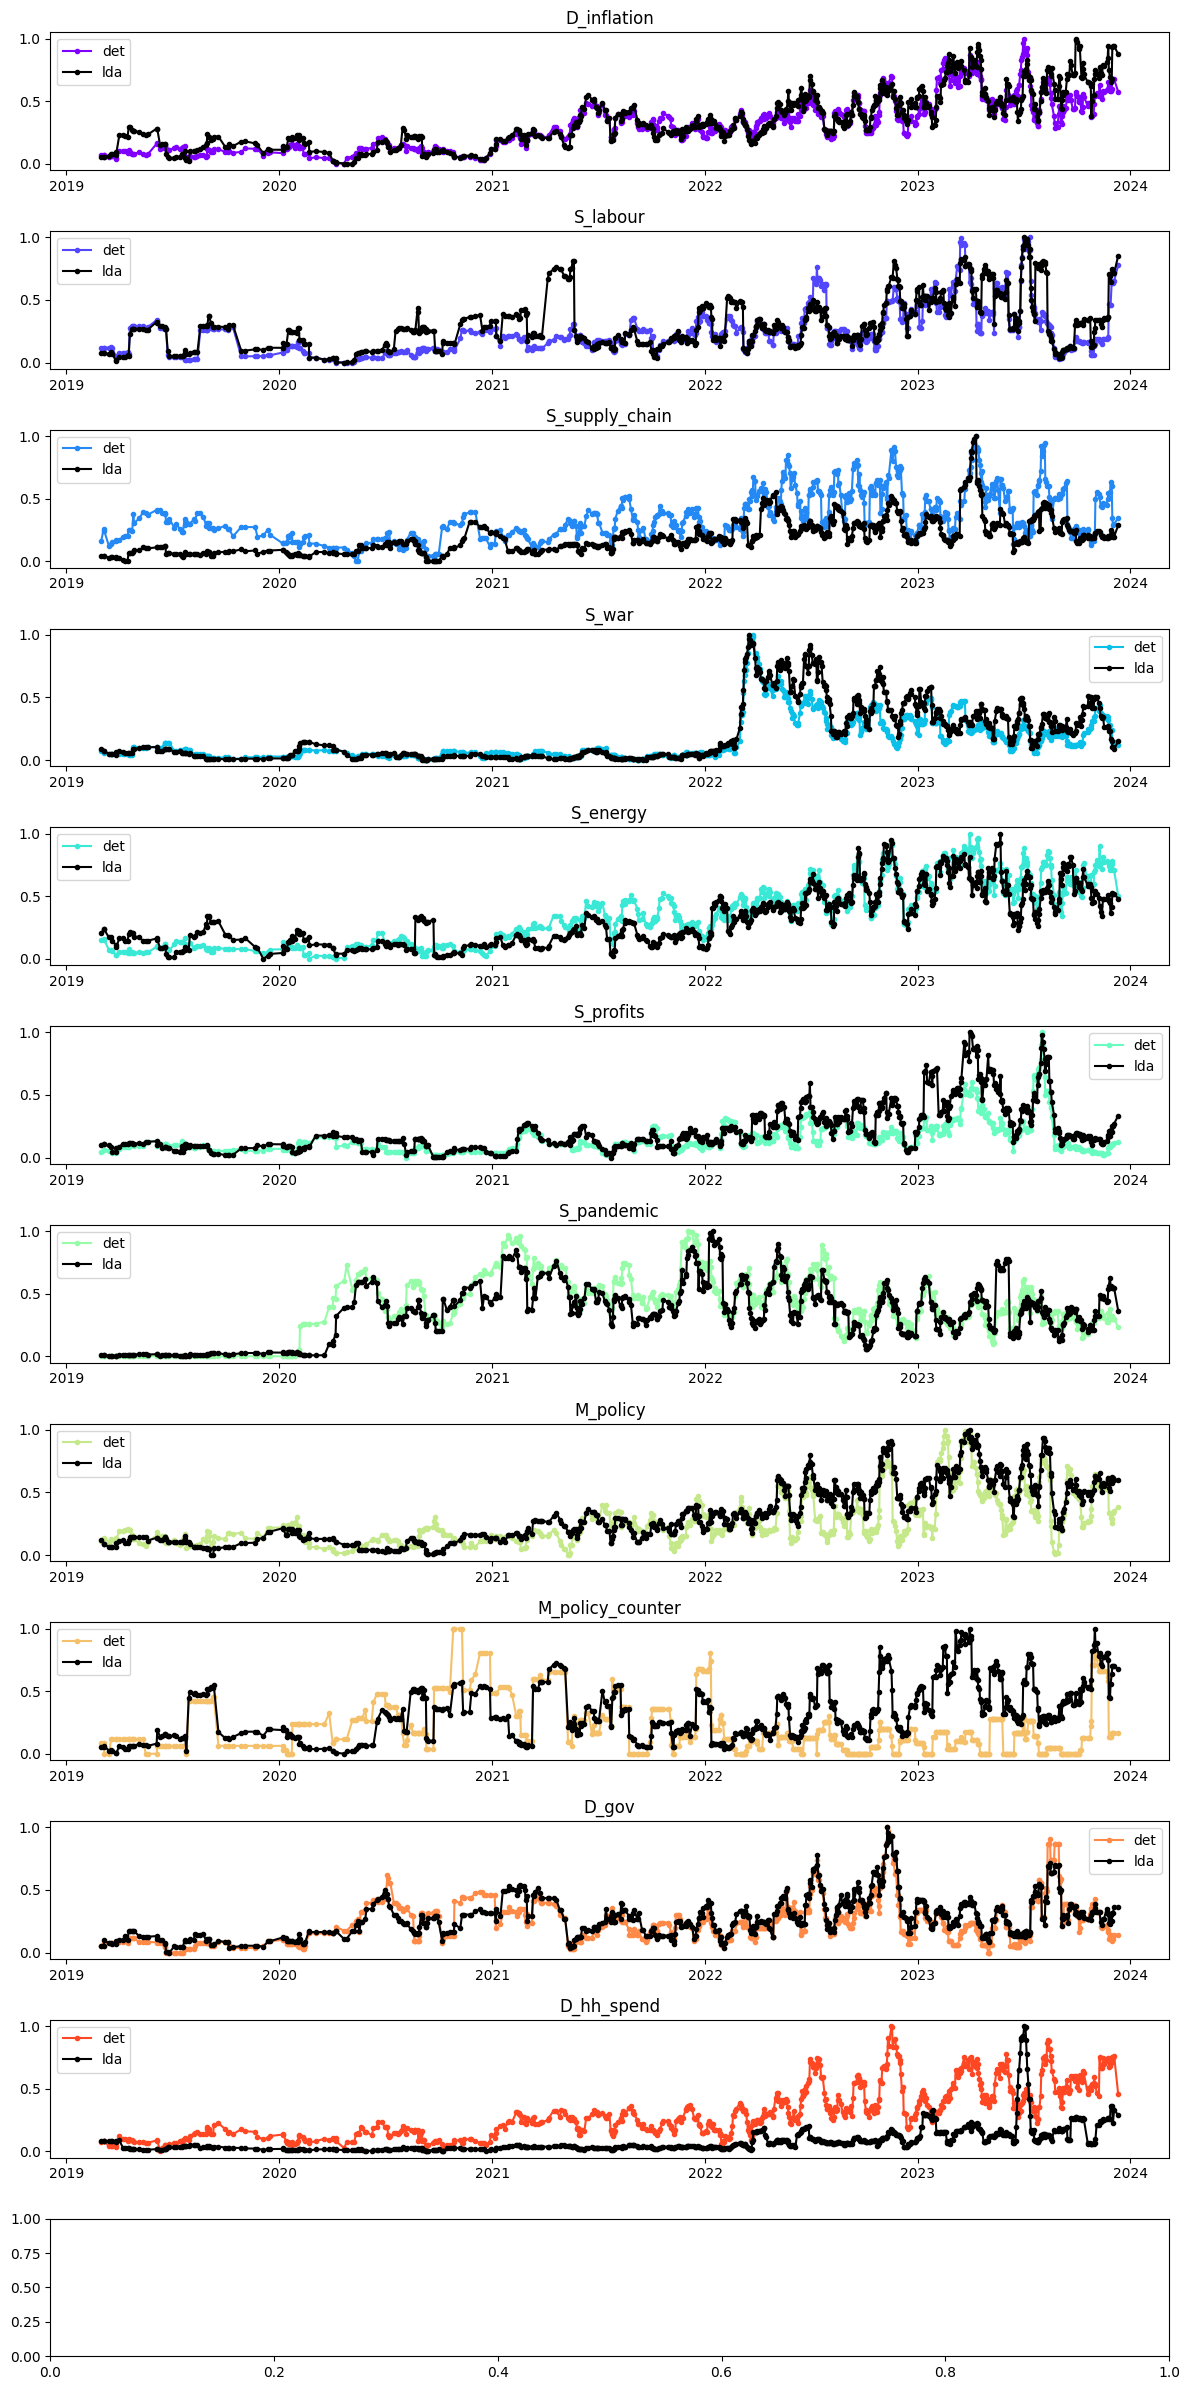

In [13]:
nrows = tlda_g.shape[1]
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

for i, ax in enumerate(axes.ravel()):
    col = tlda_g.columns[i]
    try:
        ax.plot(tdet_g.loc[:, col], c=color[i], marker='.', )
        ax.plot(tlda_g.loc[:, col], c='black', marker='.',)
    except Exception as e:
        continue
    ax.set_title(label=col)
    ax.legend(['det', 'lda'])
            
plt.tight_layout()
save_fig(fig, "02_topics_raw_det_lda.png")

# smooth

In [ ]:
# topic aggregation illustrated graphically
# in red all different models are plotted, their weighted mean is the final model
# grey presents confidence interval around final model
# blue and green show different moving averages

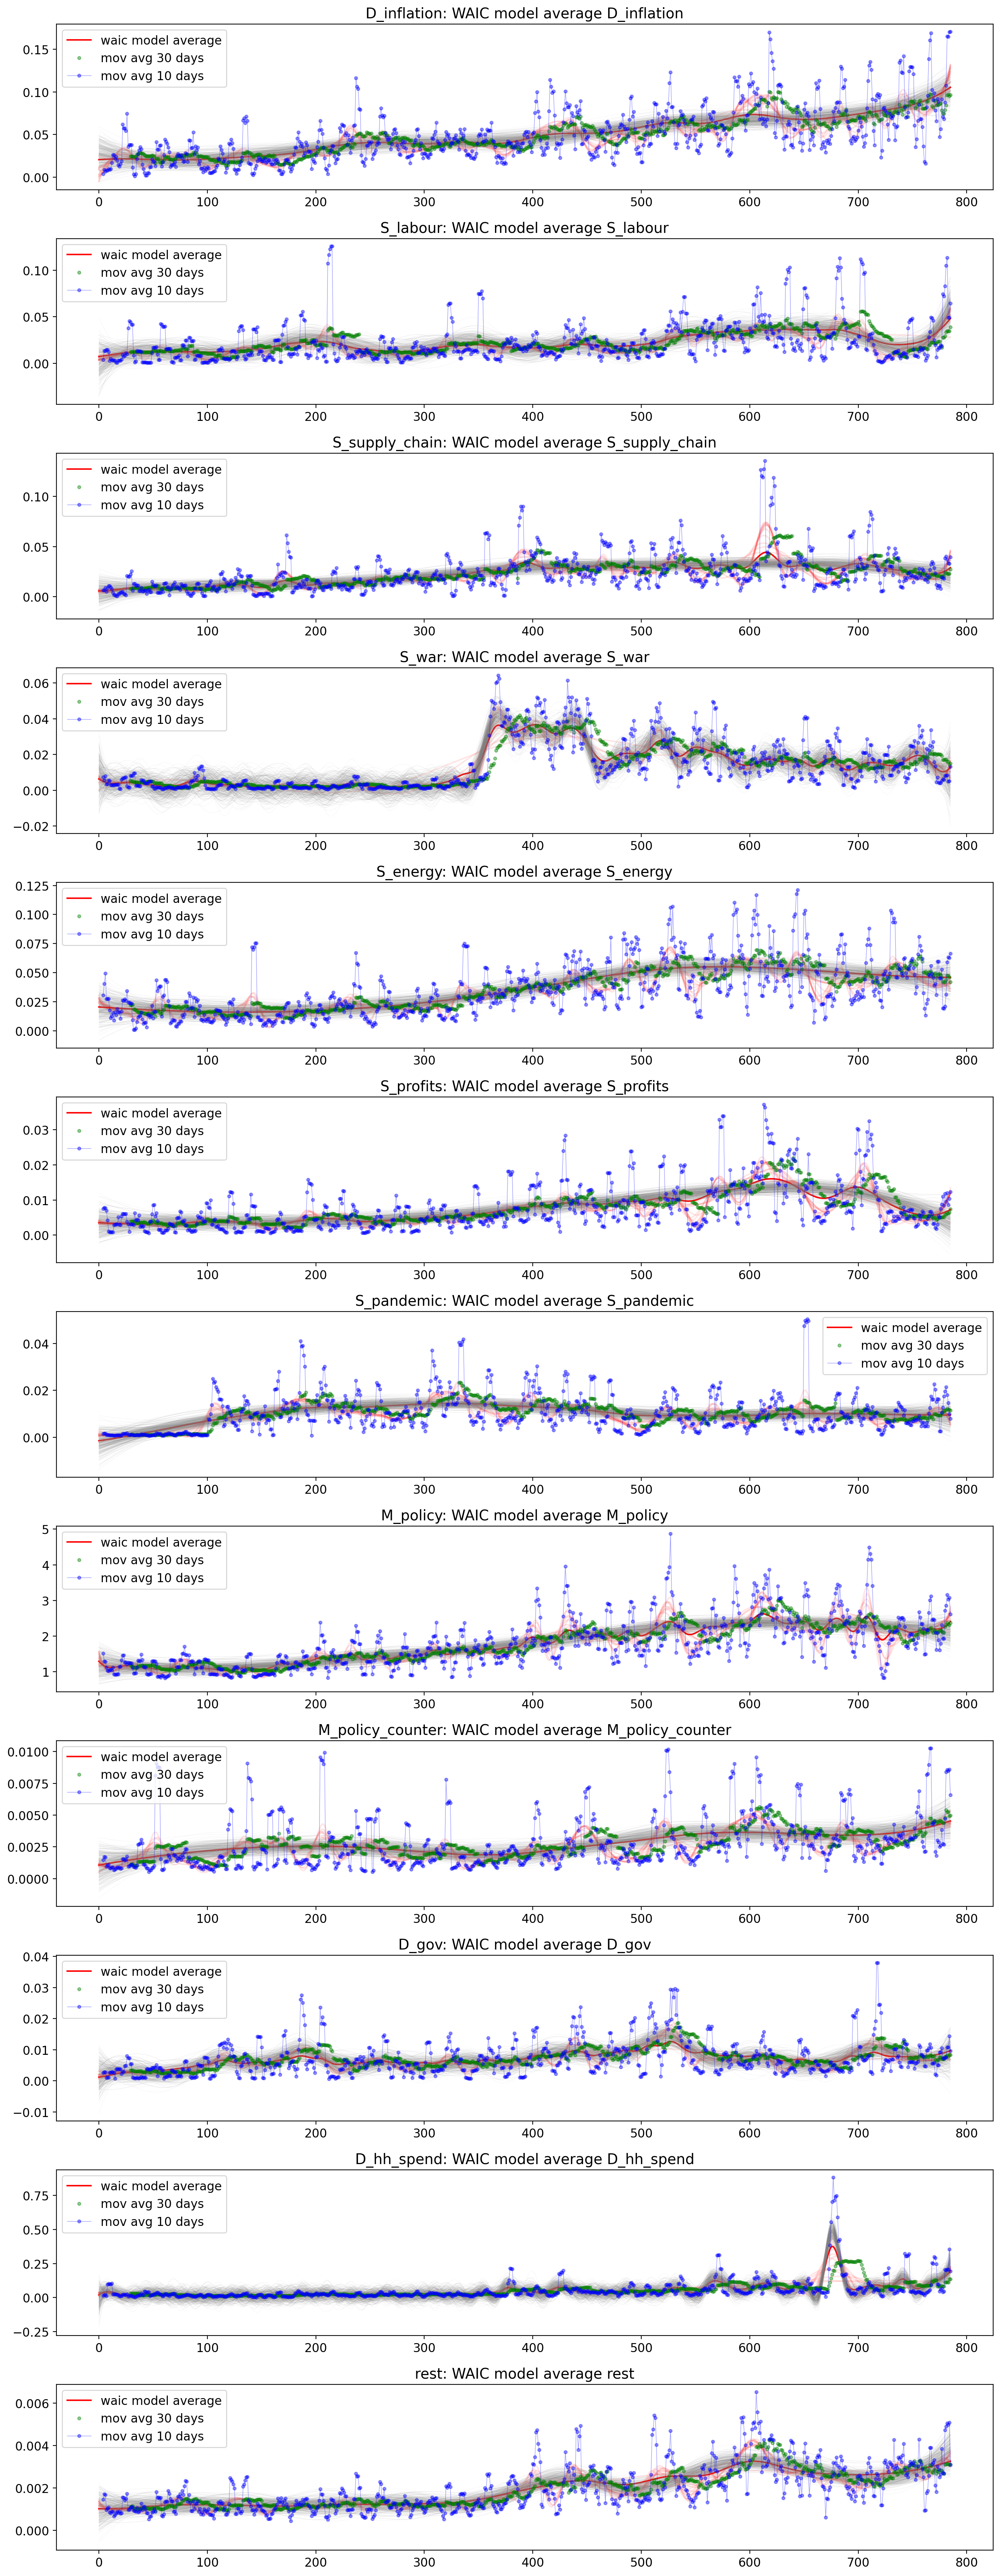

In [94]:
dict_smoothed = {}
dict_plot = {col: [dict_data_grouped[col], dict_compare_traces[col][v]] for col, v in dict_best_nknot.items()}

fig, axes = plt.subplots(len(dict_plot), 1, figsize=(14,3*len(dict_plot)), dpi=200)
for i, _ in enumerate(list(dict_plot.items())):
    col, _ = _
    data, trace = _
    
    axes.ravel()[i].plot(dict_trace_optimal_agg[col]['df'].values, color='red', alpha=.1)
    axes.ravel()[i].plot(dict_trace_optimal_agg[col]['opt_agg'].values, color='red', label='waic model average')# alpha=.2)
    
    axes.ravel()[i].set_title(f"{col}: WAIC model average {col}")
    
    axes.ravel()[i].plot(
        trace.posterior['mu'][:, get_samp(1_000, 200)].values.reshape(2*200, data.shape[0]).T,
        lw=.1,
        alpha=.3,
        color='grey',
    )
    axes.ravel()[i].plot(data.rolling(30).mean().values, lw=0, marker='.', color='green', alpha=.4, label='mov avg 30 days')
    axes.ravel()[i].plot(data.rolling(5).mean().values, lw=.5, marker='.', color='blue', alpha=.4, label='mov avg 10 days')
    # axes.ravel()[i].plot(trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, data.shape[0]).T.mean(axis=1), color='red')
    axes.ravel()[i].legend()
    
    dict_smoothed[col] = trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, data.shape[0]).T.mean(axis=1)
    
# fig.legend()
plt.tight_layout();
save_fig(fig, "02_topics_smooth_det_lda.png")